# ep1 - exploring a simple "buy dip-sell rally" trading strategy

## description and definition of the strategy

This write-up documents a first trial of the buy dip-sell rally trading strategy.  Per this strategy, one buys the dip in price along an upward overall trend and sell on a rally.

An upward overall trend is indicated by the current closing price of a stock being higher than its moving average over a past time period, $\bar{p}_{SM}(n)$, where $n$ is the size of the moving window.  A price trend signifies a dip when the current price is the lowest among the last $d$ days and a rally is signified by a highest price among the last $r$ days.

Per the description above, a particular implementation of the buy dip-sell rally strategy is parameterized by $n$, $d$ and $r$.  It is noted that implementations of the buy dip-sell rally below and in subsequent notebooks arbitrarily use $n=60$ or $n=20$, while $d$ and $r$ are optimized for each individual stock in a later notebook.

## implementation of the strategy

As a first trial, the parameters are configured as follows: $n = 60, d = 10, r = 5$ and this implementation is tested with historical prices of `SPY`.  The following function `read_stock` takes the symbol of a stock as input and returns a `DataFrame` containing historical price and other trading information.

In [1]:
import pandas as pd
import datetime
import numpy as np
import time
import matplotlib.pyplot as plt

def read_stock(symbol):
    today = datetime.date.today()
    p1 = today-datetime.timedelta(days=300)-datetime.date(1969, 12, 31)
    p2 = today-datetime.date(1969, 12, 31)
    p1 = str(int(p1.total_seconds()))
    p2 = str(int(p2.total_seconds()))
    url = 'https://query1.finance.yahoo.com/v7/finance/download/{}?P={}?period1={}&period2={}&interval=1d&events=history&includeAdjustedClose=true'
    url = url.format(symbol, symbol,p1,p2)
    try:
        df = pd.read_csv(url)
    except:
        print(symbol,' not found')
        df = []
    return df

In [3]:
df = read_stock('SPY')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-09-19,301.529999,302.630005,300.709991,301.079987,294.010406,76560500
1,2019-09-20,300.359985,300.670013,297.410004,298.279999,292.621277,89565000
2,2019-09-23,297.549988,299.000000,297.269989,298.209991,292.552582,43476800
3,2019-09-24,299.410004,299.839996,294.809998,295.869995,290.257019,94869400
4,2019-09-25,295.959991,298.109985,294.329987,297.619995,291.973816,71854000
5,2019-09-26,297.630005,297.859985,295.450012,297.000000,291.365570,56179700
6,2019-09-27,297.829987,297.950012,293.690002,295.399994,289.795929,84746600
7,2019-09-30,295.970001,297.549988,295.920013,296.769989,291.139923,51662400
8,2019-10-01,297.739990,298.459991,293.000000,293.239990,287.676880,88242400
9,2019-10-02,291.500000,291.510010,286.640015,288.059998,282.595184,122539500


The following function `proc_stock` processes the historical price and computers relavent parameters, e.g., moving average, dip and rally positions, etc., which will be later used for decision-making in trading.  Note that three variables: `win_MA`, `win_dip` and `win_ral` were defined preceding `proc_stock` to parameterize variables: $n$, $d$ and $r$ of a buy dip-sell rally strategy.

In [4]:
win_MA = 60
win_dip = 10
win_ral = 5

In [5]:
def proc_stock(df):
    if len(df) != 0:
        df.drop(['Open','High','Low','Adj Close','Volume'],axis=1,inplace=True)
        df['MA']=df['Close'].rolling(win_MA).mean()
        df['Dip']=df['Close'].rolling(win_dip).min()
        df['Rally']=df['Close'].rolling(win_ral).max()
        df['Buy'] = df.apply(buy_sig,axis=1)
        df['Sell'] = df.apply(sell_sig,axis=1)
    return df

The following two functions: `buy_sig` and `sell_sig` markes the buy and sell signals on each trading day. 

In [6]:
def buy_sig(day):
    if day['Close'] > day['MA']:        
        if day['Close'] == day['Dip']:
            return True
        else:
            return False
    else:
        return False    
def sell_sig(day):
    if day['Close'] == day['Rally']:
        return True
    else:
        return False

In [7]:
df = proc_stock(df)
df.head(10)

,Date,Close,MA,Dip,Rally,Buy,Sell
0,2019-09-19,301.079987,NaN,NaN,NaN,False,False
1,2019-09-20,298.279999,NaN,NaN,NaN,False,False
2,2019-09-23,298.209991,NaN,NaN,NaN,False,False
3,2019-09-24,295.869995,NaN,NaN,NaN,False,False
4,2019-09-25,297.619995,NaN,NaN,301.079987,False,False
5,2019-09-26,297.000000,NaN,NaN,298.279999,False,False
6,2019-09-27,295.399994,NaN,NaN,298.209991,False,False
7,2019-09-30,296.769989,NaN,NaN,297.619995,False,False
8,2019-10-01,293.239990,NaN,NaN,297.619995,False,False
9,2019-10-02,288.059998,NaN,288.059998,297.000000,False,False


The following block of code performs virtual trading and generates a plot of the evolution of the net value generated by the trading strategy, in comparison w/ the 'natural' evolution of the stock value in the absence of any trading.

In [8]:
def paper_trade(df,cash,show_steps,show_plot):
    
    try:
        n_stock = 0
        net_val = []
        benchmark_index = df[df['Buy']==True].iloc[0].name

        for i in range(0,len(df)):
            if (df.iloc[i]['Buy']==True) and cash > 0:
                n_stock = cash / df.iloc[i]['Close']
                cash = 0
                if show_steps:
                    print('executed buy at','{:.2f}'.format(df.iloc[i]['Close']),'on',df.iloc[i]['Date'])
            if (df.iloc[i]['Sell']==True) and n_stock > 0:
                cash = n_stock * df.iloc[i]['Close']
                n_stock = 0
                if show_steps:
                    print('executed sell at','{:.2f}'.format(df.iloc[i]['Close']),'on',df.iloc[i]['Date'])
            net_val.append(cash + n_stock * df.iloc[i]['Close'])

        df['Net Value']=net_val

        df['Benchmark Gain %'] = (df['Close'] - df.iloc[0]['Close']) / df.iloc[0]['Close']*100
        df['Strategy Gain %'] = (df['Net Value'] - df.iloc[benchmark_index]['Net Value']) / df.iloc[benchmark_index]['Net Value'] * 100

        benchmark_gain = int(df.iloc[-1]['Benchmark Gain %'])
        strategy_gain = int(df.iloc[-1]['Strategy Gain %'])

        if show_plot:            
            plt.plot(df.iloc[benchmark_index:]['Benchmark Gain %'],label='benchmark, '+str(benchmark_gain)+'%')
            plt.plot(df.iloc[benchmark_index:]['Strategy Gain %'],label='strategy, '+str(strategy_gain)+'%')
            plt.legend()
            plt.xlabel('trading day')
            plt.ylabel('% gain')        
            plt.show()
        return [benchmark_gain,strategy_gain]
    except:
        return [np.nan,np.nan]


executed buy at 323.50 on 2020-01-27
executed sell at 329.06 on 2020-02-04
executed buy at 281.60 on 2020-05-13
executed sell at 295.00 on 2020-05-18
executed buy at 300.61 on 2020-06-11
executed sell at 312.05 on 2020-06-23
executed buy at 300.05 on 2020-06-26
executed sell at 308.36 on 2020-06-30
executed buy at 342.57 on 2020-09-04
executed sell at 340.17 on 2020-09-15
executed buy at 330.65 on 2020-09-18
executed sell at 334.19 on 2020-09-28
executed buy at 339.39 on 2020-10-26
executed sell at 336.03 on 2020-11-03


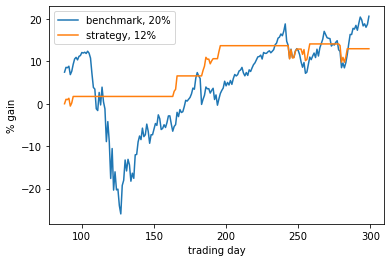


simulation took 4.26 seconds


In [9]:
t_0 = time.time()

df = read_stock('SPY')
df = proc_stock(df)
benchmark_gain,strategy_gain = paper_trade(df,1000000,show_steps=True,show_plot=True)
SPY_benchmark = benchmark_gain

t_f = time.time()

print('\nsimulation took','{:.2f}'.format(t_f-t_0),'seconds')

As can be seen from the figure above, the overall gain provided by the strategy does not appear to be significantly different from buying and holding `SPY` throughout the entire test period.  However, it does appear that the strategy avoids catastrophical loss of capital due to a recession and the resulting signficant retraction of `SPY` value.

## performance characteristics of the aforementioned strategy on other SP500 stocks

It is of interest to observe the performance characteristics of the aforementioned strategy on other SP500 stocks, **without tuning of** $n$, $d$ and $r$.  One can adjust the three parameters in the trading strategy to maximize the gain from exercising this strategy on a particular stock.  However, such optimization is not the objective of the exploration discussed in this section.  The objective of this section is to develop a 'feeling' of how this strategy would generate qualitatively different performance characteristics when it is applied to a variety of SP500 stocks. The following line of code loads a pre-made list of SP500 stocks stored in `SP500 list.csv`.

In [10]:
df_SP500 = pd.read_csv('SP500 list.csv')
pd.set_option('display.max_rows', 600)
df_SP500.head(10)

,Symbol,Security,GICSSector,GICS Sub-Industry
0,MMM,3M Company,Industrials,Industrial Conglomerates
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals
3,ABMD,ABIOMED Inc,Health Care,Health Care Equipment
4,ACN,Accenture plc,Information Technology,IT Consulting & Other Services
5,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment
6,ADBE,Adobe Inc.,Information Technology,Application Software
7,AMD,Advanced Micro Devices Inc,Information Technology,Semiconductors
8,AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail
9,AES,AES Corp,Utilities,Independent Power Producers & Energy Traders


In the code block below we pacakge the aforementioned workflow developed to perform paper trading on one stock into a function, such that this function can be repeatedly apply to each and every element of the list of SP500 stocks.  This calculation step is relatively time-consuming.  Therefore, we also save the results in a `.csv`, such that we can continue the analysis on the results without having to repeat this time-consuming calculation step.

In [12]:
def trade_single(symbol):
    df = read_stock(symbol)
    df = proc_stock(df)
    benchmark_gain,strategy_gain = paper_trade(df,1000000,show_steps=False,show_plot=False)
    return [benchmark_gain,strategy_gain]

In [13]:
t_0 = time.time()  # here we use the time module to time our execution of the line below
res = df_SP500['Symbol'].apply(trade_single)
t_f = time.time()
print('simulation took','{:.2f}'.format(t_f-t_0),'seconds to finish')

simulation took 517.56 seconds to finish


The following code block compiles a summary of the benchmark gain% and strategy gain% for each stock in SP500.

In [14]:
df_res = pd.DataFrame(list(res),columns=['Benchmark Gain %','Strategy Gain %'])
df_res['Benchmark Gain %'] = pd.to_numeric(df_res['Benchmark Gain %'])
df_res['Strategy Gain %'] = pd.to_numeric(df_res['Strategy Gain %'])
df_res['Diff Gain %']=df_res['Strategy Gain %'] - df_res['Benchmark Gain %']
df_SP500 = pd.concat([df_SP500,df_res],axis=1)
df_SP500.to_csv('SP500_simple_bdsr_res.csv')
df_SP500.head(10)

,Symbol,Security,GICSSector,GICS Sub-Industry,Benchmark Gain %,Strategy Gain %,Diff Gain %
0,MMM,3M Company,Industrials,Industrial Conglomerates,5.0,-3.0,-8.0
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment,29.0,15.0,-14.0
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals,45.0,-4.0,-49.0
3,ABMD,ABIOMED Inc,Health Care,Health Care Equipment,38.0,9.0,-29.0
4,ACN,Accenture plc,Information Technology,IT Consulting & Other Services,28.0,8.0,-20.0
5,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment,36.0,31.0,-5.0
6,ADBE,Adobe Inc.,Information Technology,Application Software,64.0,15.0,-49.0
7,AMD,Advanced Micro Devices Inc,Information Technology,Semiconductors,180.0,11.0,-169.0
8,AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail,-1.0,9.0,10.0
9,AES,AES Corp,Utilities,Independent Power Producers & Energy Traders,32.0,-28.0,-60.0


The following code block displays the list of stocks on which if the strategy were exercised, would have produced significantly higher gain % than buying and holding the stock without trading.  Notably, the absolute strategy gain % produced with these stocks are universally above the % gain observed with `SPY`.

In [15]:
df_strategy_preferred = df_SP500[df_SP500['Strategy Gain %'] > df_SP500['Benchmark Gain %']]
df_profitable = df_strategy_preferred[df_strategy_preferred['Strategy Gain %'] > SPY_benchmark]
pd.set_option('display.max_rows', 500)
df_profitable.sort_values(by='Strategy Gain %',ascending=False)

,Symbol,Security,GICSSector,GICS Sub-Industry,Benchmark Gain %,Strategy Gain %,Diff Gain %
206,GPS,Gap Inc.,Consumer Discretionary,Apparel Retail,53.0,80.0,27.0
84,COF,Capital One Financial,Financials,Consumer Finance,-2.0,42.0,44.0
158,DD,DuPont de Nemours Inc,Materials,Specialty Chemicals,-7.0,40.0,47.0
48,APTV,Aptiv PLC,Consumer Discretionary,Auto Parts & Equipment,35.0,36.0,1.0
471,VRTX,Vertex Pharmaceuticals Inc,Health Care,Biotechnology,22.0,36.0,14.0
347,NUE,Nucor Corp.,Materials,Steel,7.0,34.0,27.0
407,SBAC,SBA Communications,Real Estate,Specialized REITs,11.0,30.0,19.0
325,MOS,The Mosaic Company,Materials,Fertilizers & Agricultural Chemicals,10.0,29.0,19.0
180,EXPE,Expedia Group,Consumer Discretionary,Internet & Direct Marketing Retail,-7.0,28.0,35.0
222,HAS,Hasbro Inc.,Consumer Discretionary,Leisure Products,-23.0,27.0,50.0


### exploring sector-specificity of the performance characteristics

The code block below generates two pie charts that present the distributions of strategy-preferred stocks among different sectors and the distribution of all stocks in S&P500 among different sectors.

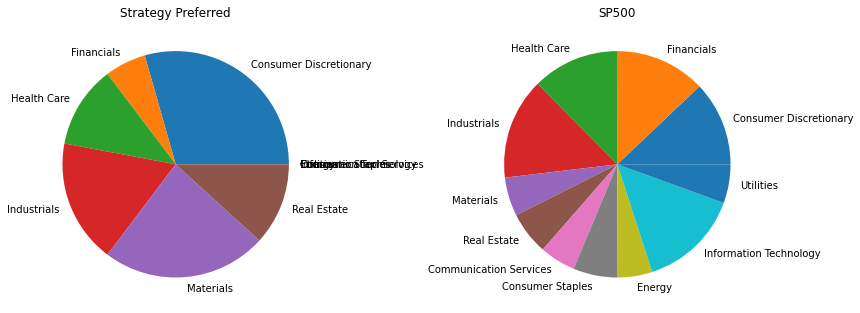

In [16]:
df_strategy_by_sector = df_profitable[['Symbol','GICSSector']].groupby(['GICSSector']).count().rename(columns={'Symbol':'Strategy Preferred'})
df_SP500_by_sector = df_SP500[['Symbol','GICSSector']].groupby(['GICSSector']).count().rename(columns={'Symbol':'SP500'})
comp_by_sector = pd.concat([df_strategy_by_sector,df_SP500_by_sector],axis=1)
comp_by_sector.replace({np.nan:0},inplace=True)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6),tight_layout=True)
ax1.pie(comp_by_sector['Strategy Preferred'].values,labels=comp_by_sector.index)
ax1.set_title('Strategy Preferred')
ax2.pie(comp_by_sector['SP500'].values,labels=comp_by_sector.index)
ax2.set_title('SP500')
plt.show()

It apeears that the trading strategy under consideration performs well on the 'Materials' sector.  Some top performers are enumerated: `NUE`,`MOS`,`DOW`.  One can pass these symbols to the `symbol` variable in the code block below and execute the code to observe the steps the trading strategies would have taken to realize such differentiated gain %. 

executed buy at 56.08 on 2019-12-30
executed sell at 54.00 on 2020-01-14
executed buy at 39.01 on 2020-05-12
executed sell at 40.86 on 2020-05-18
executed buy at 39.66 on 2020-06-11
executed sell at 44.59 on 2020-06-16
executed buy at 40.60 on 2020-06-26
executed sell at 41.65 on 2020-07-06
executed buy at 44.69 on 2020-08-21
executed sell at 46.64 on 2020-09-01
executed buy at 45.39 on 2020-09-10
executed sell at 46.73 on 2020-09-14
executed buy at 44.67 on 2020-09-23
executed sell at 46.27 on 2020-09-28
executed buy at 48.51 on 2020-10-20
executed sell at 49.90 on 2020-10-22
executed buy at 48.28 on 2020-10-26
executed sell at 48.87 on 2020-11-02


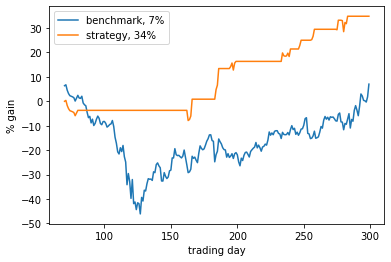


simulation took 1.83 seconds


In [18]:
t_0 = time.time()
df = read_stock('NUE')
df = proc_stock(df)
benchmark_gain,strategy_gain = paper_trade(df,1000000,show_steps=True,show_plot=True)
SPY_benchmark = benchmark_gain
t_f = time.time()
print('\nsimulation took','{:.2f}'.format(t_f-t_0),'seconds')

It would also be interesting to inspect the efficacy of this trading strategy on stocks from the other sectors, on which it has performed well.  The stocks from the other sectors on which this strategy generated high returns are listed below.

In [19]:
ls=[]
for name,group in df_profitable.groupby(['GICSSector']):
    stock = group.sort_values(by=['Diff Gain %'],ascending=False).iloc[0][['Symbol','GICS Sub-Industry']].values
    ls.append([name,stock[0],stock[1]])
df_stock_by_sector = pd.DataFrame(ls,columns=(['GICSSector','Symbol','GICS Sub-Industry']))
df_stock_by_sector

,GICSSector,Symbol,GICS Sub-Industry
0,Consumer Discretionary,HAS,Leisure Products
1,Financials,COF,Consumer Finance
2,Health Care,ILMN,Life Sciences Tools & Services
3,Industrials,J,Construction & Engineering
4,Materials,DD,Specialty Chemicals
5,Real Estate,SBAC,Specialized REITs


The following code block performs paper trading on all the stocks listed above w/ the simple buy dip-sell rally strategy.  It is noted that the `paper_trade` function was slightly modified to be able to plot the resulting evolution of %gain on different corresponding subplots.

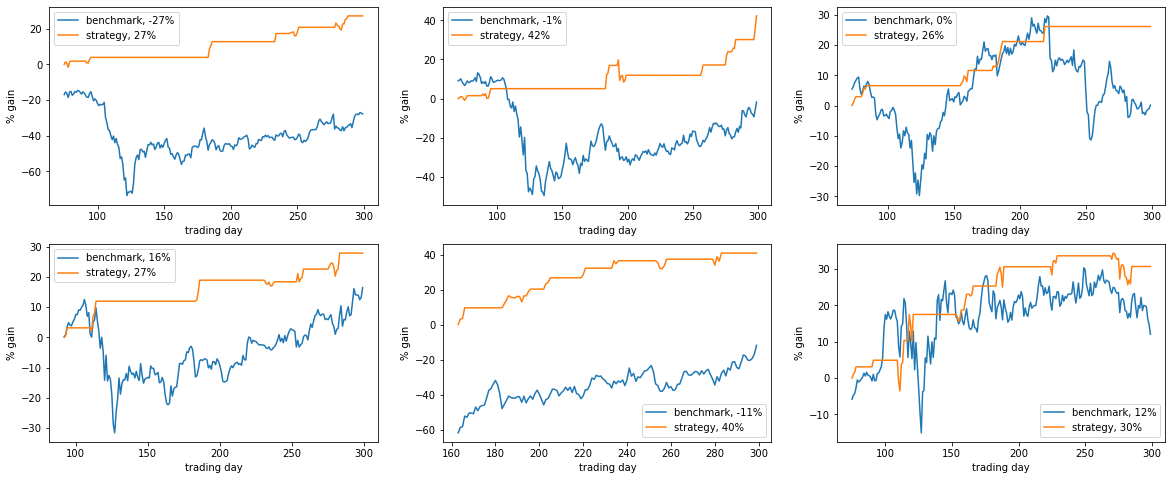

In [22]:
def paper_trade_subplot(df,cash,plot_ax):
    
    try:
        n_stock = 0
        net_val = []
        benchmark_index = df[df['Buy']==True].iloc[0].name

        for i in range(0,len(df)):
            if (df.iloc[i]['Buy']==True) and cash > 0:
                n_stock = cash / df.iloc[i]['Close']
                cash = 0                                
            if (df.iloc[i]['Sell']==True) and n_stock > 0:
                cash = n_stock * df.iloc[i]['Close']
                n_stock = 0                                
            net_val.append(cash + n_stock * df.iloc[i]['Close'])

        df['Net Value']=net_val

        df['Benchmark Gain %'] = (df['Close'] - df.iloc[0]['Close']) / df.iloc[benchmark_index]['Close']*100
        # df['Benchmark Gain %'] = (df['Close'] - df.iloc[benchmark_index]['Close']) / df.iloc[benchmark_index]['Close']*100
        df['Strategy Gain %'] = (df['Net Value'] - df.iloc[benchmark_index]['Net Value']) / df.iloc[benchmark_index]['Net Value'] * 100

        benchmark_gain = int(df.iloc[-1]['Benchmark Gain %'])
        strategy_gain = int(df.iloc[-1]['Strategy Gain %'])

        plot_ax.plot(df.iloc[benchmark_index:]['Benchmark Gain %'],label='benchmark, '+str(benchmark_gain)+'%')
        plot_ax.plot(df.iloc[benchmark_index:]['Strategy Gain %'],label='strategy, '+str(strategy_gain)+'%')
        plot_ax.legend()
        plot_ax.set_xlabel('trading day')
        plot_ax.set_ylabel('% gain')        

        return [benchmark_gain,strategy_gain]
    except:
        return [np.nan,np.nan]

fig,ax = plt.subplots(2,3,figsize=(20,8))
list_ax = ax.reshape(1,6)[0]

for i in range(0,len(df_stock_by_sector)):
    df = read_stock(df_stock_by_sector.iloc[i]['Symbol'])
    df = proc_stock(df)
    benchmark_gain,strategy_gain = paper_trade_subplot(df,1000000,list_ax[i])

As can be seen from the figures above, the strategy worked on stocks with certain patterns in the price evolution.  For example, it appears that the strategy was particularily good at avoiding significant retractions.  It would also be interesting to know on which stocks, the strategy did not work.  We will perform this exploration in the next notebook.